<a href="https://colab.research.google.com/github/mickeykubo/analytics_book/blob/master/forecast1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Prophetによる時系列データの予測

Prophetは，Facebookが公開している予測パッケージである． 

## インストール

### Macの場合
```
conda-forge: conda install -c conda-forge fbprophet
```

### Google Colabの場合
```
# !pip install fbprophet
```

Windowsにインストールする際には，C言語のコンパイラが必要

https://github.com/facebook/prophet

参照

In [1]:
!pip install fbprophet

# 諸パッケージのインポート

In [0]:
import pandas as pd
from fbprophet import Prophet
from vega_datasets import data
import plotly.express as px
import fbprophet.plot as fp
import plotly.io as pio
pio.renderers.default = "colab"

## 基本的な使い方

ProphetをPythonから呼び出して使う方法は，機械学習パッケージscikit learnと同じである。



1.   **Prophet**クラスのインスタンス**model**を生成
2.   **fit**メソッドで学習（引数はデータフレーム）
3.   **predict**メソッドで予測（引数は予測したい期間を含んだデータフレーム）

例としてアメリカンフットボールプレーヤのPayton ManningのWikiアクセス数のデータを用いる。

In [4]:
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


Prophetモデルのインスタンスを生成し，fitメソッドで学習（パラメータの最適化）を行う．fitメソッドに渡すのは，上で作成したデータフレームである．このとき、**ds**列に日付（時刻）を、**y**列に予測したい数値を入れておく必要がある。
（この例題では，あらかじめそのように変更されている．）


In [6]:
model = Prophet()
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**make_future_dataframe**メソッドで未来の時刻を表すデータフレームを生成する。既定値では、予測で用いた過去の時刻も含む。
引数は予測をしたい期間数**periods**であり，ここでは、１年後（365日分）まで予測することにする。

In [8]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


predict メソッドに予測したい時刻を含んだデータフレームfuture を渡すと、予測値を入れたデータフレームforecastを返す。このデータフレームは、予測値yhatの他に、予測の幅などの情報を含んだの列を含む。以下では，予測値yhatの他に，予測の上限と下限（yhat_lowerとyhat_upper）を表示している．

In [10]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.199274,7.540009,8.964603
3266,2017-01-16,8.524244,7.834114,9.211635
3267,2017-01-17,8.311615,7.551191,9.034179
3268,2017-01-18,8.144232,7.385010,8.879308
3269,2017-01-19,8.156091,7.403408,8.908380


matplotlibを用いた描画は，plotメソッドで行う．

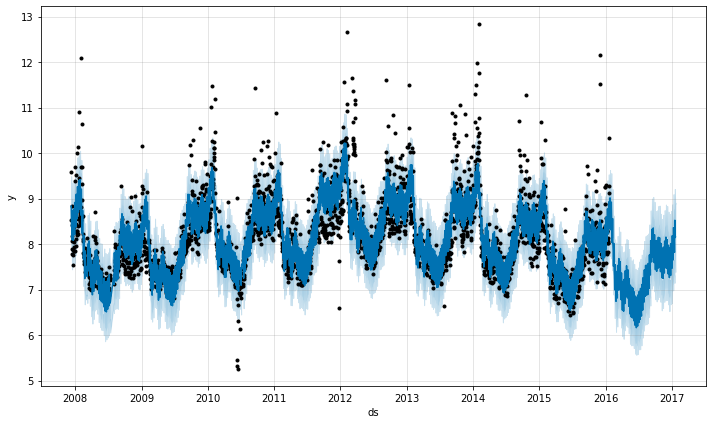

In [12]:
model.plot(forecast);

Prophetにおける予測は一般化加法モデルを用いて行われる．これは，傾向変動，季節変動，イベント情報などの様々な因子の和として予測を行う方法である．

###一般化線形モデル

$$
 y_t =g_t + s_t + h_t + \epsilon_t 
$$

- $y_t$ : 予測値
- $g_t$ : 傾向変動(trend)；傾向変化点ありの線形もしくはロジスティック曲線
- $s_t$ : 季節変動；年次，週次，日時の季節変動をsin,cosの組み合わせで表現
- $h_t$ : 休日などのイベント項
- $\epsilon_t$: 誤差項


因子ごとに予測値の描画を行うには，plot_componentsメソッドを用いる．既定では，以下のように，上から順に傾向変動，週次の季節変動，年次の季節変動が描画される．また，傾向変動の図（一番上）には，予測の誤差範囲が示される．季節変動の誤差範囲を得る方法については，後述する．


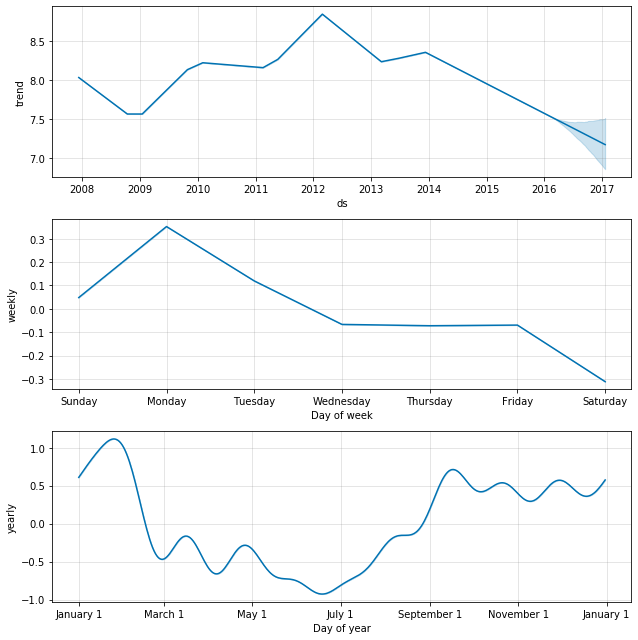

In [14]:
model.plot_components(forecast);

対話形式に，拡大縮小や範囲指定ができる動的な図も，Plotlyライブラリを用いて得ることができる．

In [17]:
fig = fp.plot_plotly(model, forecast)  # This returns a plotly Figure
fig.show()

# CO2排出量のデータ

データライブラリから読み込み，Plotly Expressで描画する．

In [7]:
co2 = data.co2_concentration()
co2.head()

,Date,CO2
0,1958-03-01,315.70
1,1958-04-01,317.46
2,1958-05-01,317.51
3,1958-07-01,315.86
4,1958-08-01,314.93


In [4]:
px.line(co2,x="Date",y="CO2")


列名の変更には，データフレームの**rename**メソッドを用いる．引数は**columns**で，元の列名をキーとし，変更後の列名を値とした辞書を与える．また，元のデータフレームに上書きするために，**inplace**引数を**True**に設定しておく．

make_future_dataframe`で未来の時刻を表すデータフレームを生成する。既定値では、（予測で用いた）過去の時刻も含む。
ここでは、200ヶ月先まで予測することにする。

そのために，引数**periods**を200に，頻度を表す引数**freq**をMonthを表す**'M'**に設定しておく

predict メソッドに予測したい時刻を含んだデータフレームfuture を渡すと、予測値を入れたデータフレームforecastを返す。このデータフレームは、予測値yhatの他に、予測の幅などの情報を含んだの列を含む。

最後にplotメソッドで表示する．

In [0]:
co2.rename(columns={"Date":"ds","CO2":"y"},inplace=True)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


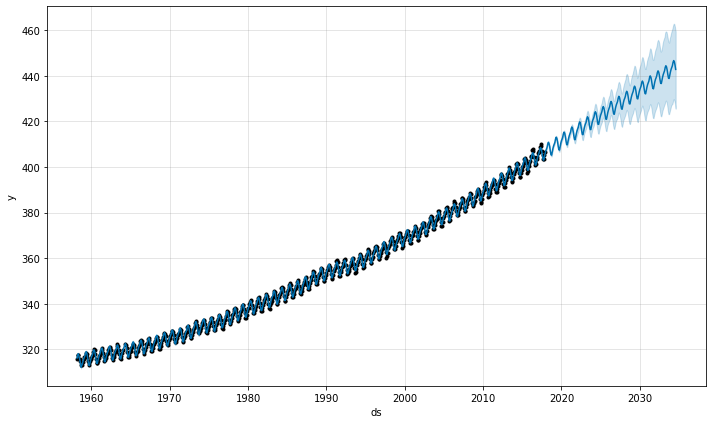

In [6]:
model = Prophet()
model.fit(co2)
future = model.make_future_dataframe(periods=200, freq='M')
forecast = model.predict(future)
model.plot(forecast);

予測は一般化加法モデルを用いて行われる．

これは，傾向変動，季節変動，イベント情報などの様々な因子の和として予測を行う方法である．

上に表示されているように，週次と日時の季節変動は無視され，年次の季節変動のみ考慮して予測している．


因子ごとに予測値の描画を行うには，plot_componentsメソッドを用いる．既定では，以下のように，上から順に傾向変動，週次の季節変動，年次の季節変動が描画される．また，傾向変動の図（一番上）には，予測の誤差範囲が示される．季節変動の誤差範囲を得る方法については，後述する．

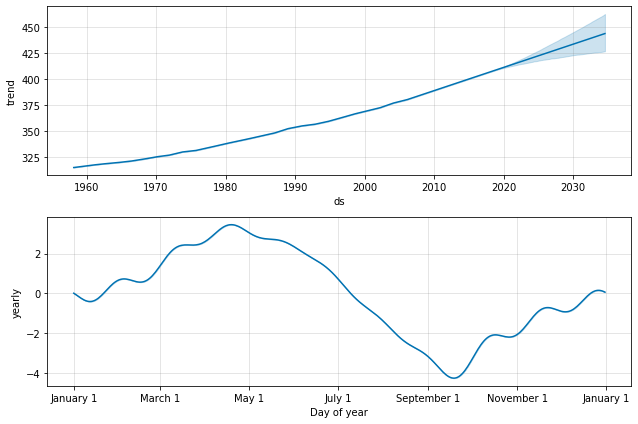

In [0]:
model.plot_components(forecast);

## Plotlyで描画

一部を拡大，期の選択などが可能になる．

In [0]:
fig = fp.plot_plotly(model, forecast)
fig.show()

# 航空機乗客数のデータ

## 季節変動を加法的でなく乗法的にする．

In [0]:
passengers = pd.read_csv("http://logopt.com/data/AirPassengers.csv")
passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [0]:
px.line(passengers,x="Month",y="#Passengers")

In [0]:
passengers.rename(inplace=True,columns={"Month":"ds","#Passengers":"y"})
passengers.head()

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Prophetの規定値では季節変動は加法的モデルであるが、問題によっては乗法的季節変動の方が良い場合もある。例として、航空機の乗客数を予測してみよう。最初に既定値の加法的季節変動モデルで予測し，次いで乗法的モデルで予測する．

そのためには，モデルの**seasonality_mode**を**'multiplicative'**に設定する．

なお，以下のデータは月次のデータであるので，make_future_dataframeの**freq**引数を**'M'**(Month)に設定する．

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


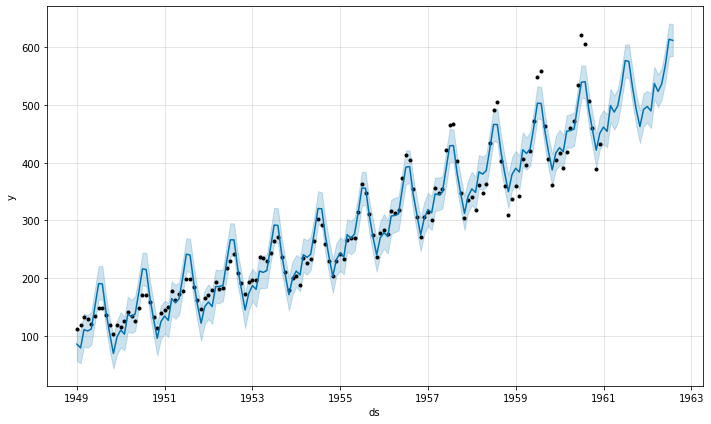

In [0]:
model = Prophet().fit(passengers)
future = model.make_future_dataframe(periods=20, freq='M')
forecast = model.predict(future)
model.plot(forecast);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


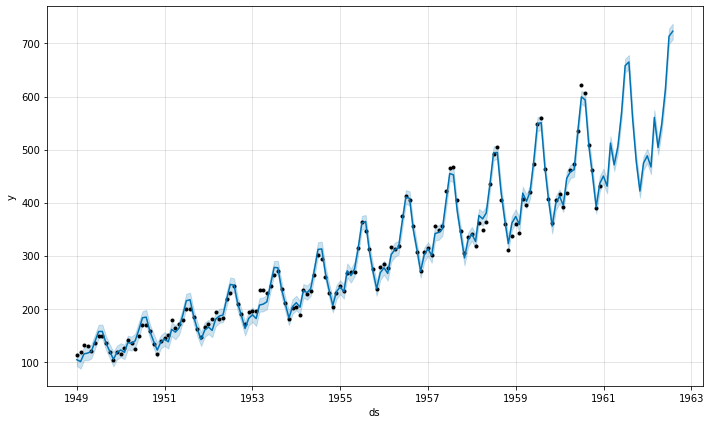

In [0]:
model = Prophet(seasonality_mode='multiplicative').fit(passengers)
future = model.make_future_dataframe(periods=20, freq='M')
forecast = model.predict(future)
model.plot(forecast);

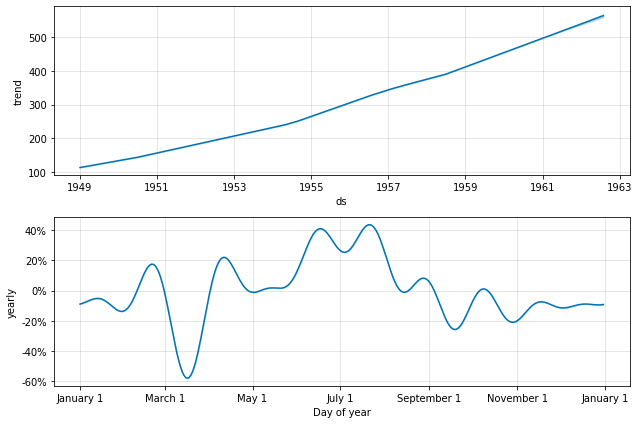

In [0]:
model.plot_components(forecast);

## 問題

以下の，小売りの需要データを描画し，予測を行え．
ただし，モデルは乗法的季節変動で，月次で予測せよ．

In [10]:
retail = pd.read_csv('http://logopt.com/data/retail_sales.csv')
retail.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


# 1時間ごとの気温データ

**DATE**列に日付と時間（1時間ごと）が，**HLY-TEMP-NORMAL**列に気温データが入っている．


## 日付未満のデータ

日別でないデータも扱うことができる。データ形式は、日付を表す`YYYY-MM-DD`の後に時刻を表す`HH:MM:SS`が追加されている。
未来の時刻を表すデータフレームは、`make_future_dataframe`メソッドで生成するが、このとき引数`freq`で時間の刻みを指定する。 ここでは1時間を表す'H'を指定する。


In [0]:
climate = data.climate()
climate.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HLY-TEMP-NORMAL,HLY-PRES-NORMAL,HLY-DEWP-NORMAL
0,GHCND:USW00003812,ASHEVILLE REGIONAL AIRPORT NC US,645.3,35.43194,-82.5375,2010-01-01 00:00:00,349,10205,289
1,GHCND:USW00003812,ASHEVILLE REGIONAL AIRPORT NC US,645.3,35.43194,-82.5375,2010-01-01 01:00:00,344,10202,287
2,GHCND:USW00003812,ASHEVILLE REGIONAL AIRPORT NC US,645.3,35.43194,-82.5375,2010-01-01 02:00:00,339,10200,284
3,GHCND:USW00003812,ASHEVILLE REGIONAL AIRPORT NC US,645.3,35.43194,-82.5375,2010-01-01 03:00:00,334,10202,283
4,GHCND:USW00003812,ASHEVILLE REGIONAL AIRPORT NC US,645.3,35.43194,-82.5375,2010-01-01 04:00:00,331,10202,280


In [0]:
climate["Date"] = pd.to_datetime(climate.DATE)

In [0]:
climate.rename(columns={"Date":"ds","HLY-TEMP-NORMAL":"y"},inplace=True)

In [0]:
px.line(climate,x="ds",y="y")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


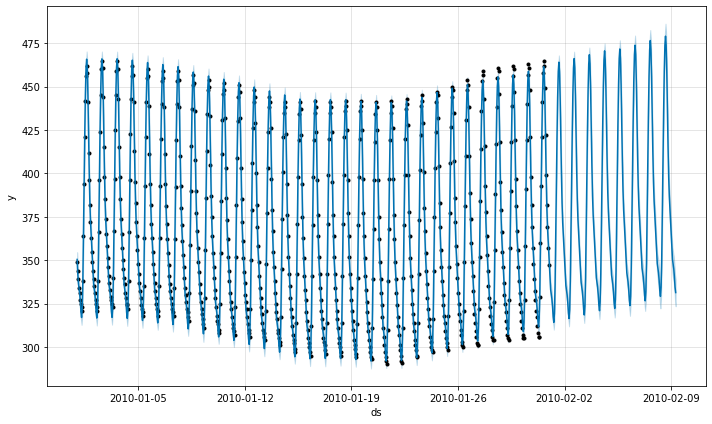

In [0]:
model = Prophet().fit(climate)
future = model.make_future_dataframe(periods=200, freq='H')
forecast = model.predict(future)
model.plot(forecast);

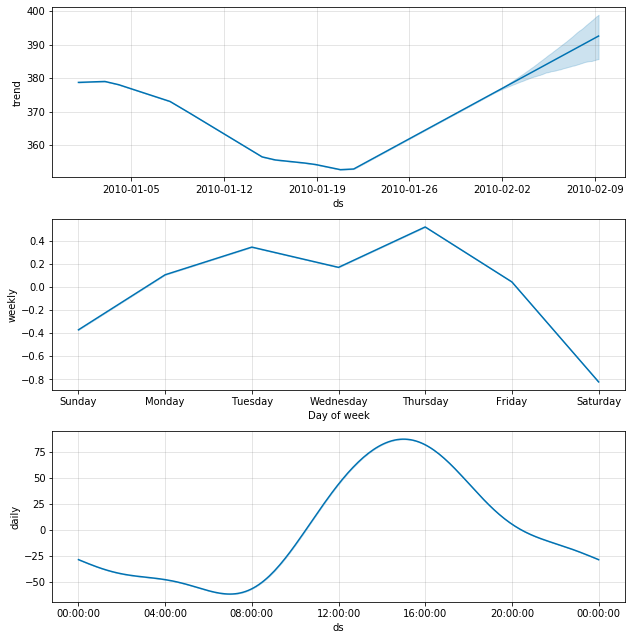

In [0]:
model.plot_components(forecast);

## 問題

以下のサンフランシスコの気温データを描画し，時間単位で予測を行え．

In [59]:
sf = data.sf_temps()
sf.head()

,temp,date
0,47.8,2010-01-01 00:00:00
1,47.4,2010-01-01 01:00:00
2,46.9,2010-01-01 02:00:00
3,46.5,2010-01-01 03:00:00
4,46.0,2010-01-01 04:00:00


# Githubのアクセス数データ

## 誤差が正規分布でない場合の取り扱い

In [9]:
github = data.github()
github.tail()

,time,count
950,2015-05-29 17:00:00,1
951,2015-05-29 19:00:00,1
952,2015-05-30 00:00:00,10
953,2015-05-30 09:00:00,1
954,2015-05-30 11:00:00,2


In [4]:
px.line(github,x="time",y="count")

# 累積量を計算

**cumsum**で累積和（cumulative sum）が計算できる．

これを用いて予測する．

誤差が正規分布に近いことが確認できる．

他の方法（予測したいものの対数をとるなどの方法）だとうまくいかないことを確認せよ．

In [35]:
github["cumsum"] = github["count"].cumsum()
github.head()

,time,count,cumsum
0,2015-01-01 01:00:00,2,2
1,2015-01-01 04:00:00,3,5
2,2015-01-01 05:00:00,1,6
3,2015-01-01 08:00:00,1,7
4,2015-01-01 09:00:00,3,10


In [36]:
github.rename(inplace=True,columns={"time":"ds","cumsum":"y"})
github.head()

,ds,count,y
0,2015-01-01 01:00:00,2,2
1,2015-01-01 04:00:00,3,5
2,2015-01-01 05:00:00,1,6
3,2015-01-01 08:00:00,1,7
4,2015-01-01 09:00:00,3,10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


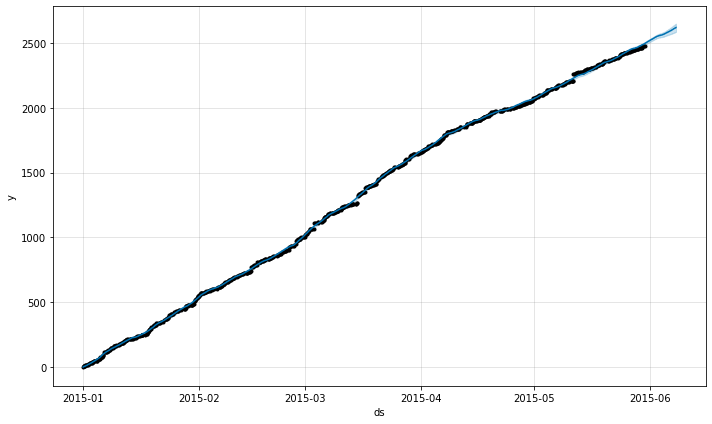

In [37]:
model = Prophet().fit(github)
future = model.make_future_dataframe(periods=200, freq='H')
forecast = model.predict(future)
model.plot(forecast);

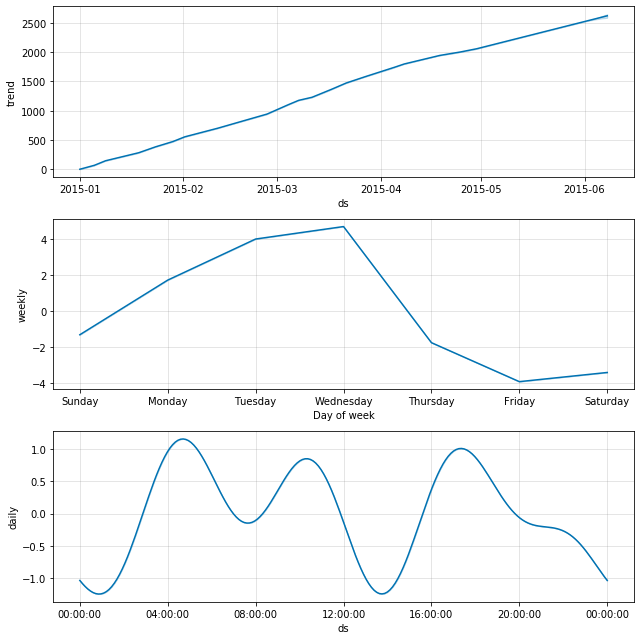

In [39]:
model.plot_components(forecast);

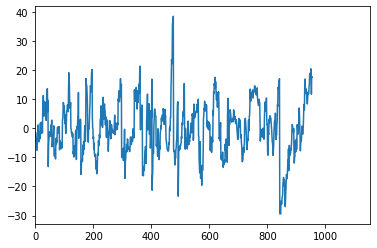

In [0]:
forecast["error"] = forecast.yhat - github.y
forecast["error"].plot()

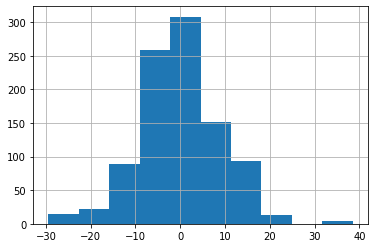

In [0]:
forecast["error"].hist()


# 傾向変化点

「上昇トレンドの株価が，下降トレンドに移った」というニュースをよく耳にするだろう．このように，傾向変動は，時々変化すると仮定した方が自然なのだ．Prophetでは，これを傾向の変化点として処理する．再び，Peyton Manningのデータを使う．

add_changepoints_to_plotを使うと、変化した点（日次）と傾向変動を図に追加して描画できる。引数は軸(axis)，モデル(model)，予測データフレーム(forecast)であり，
軸は図オブジェクトのgca(get current axis)メソッドで得る．

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


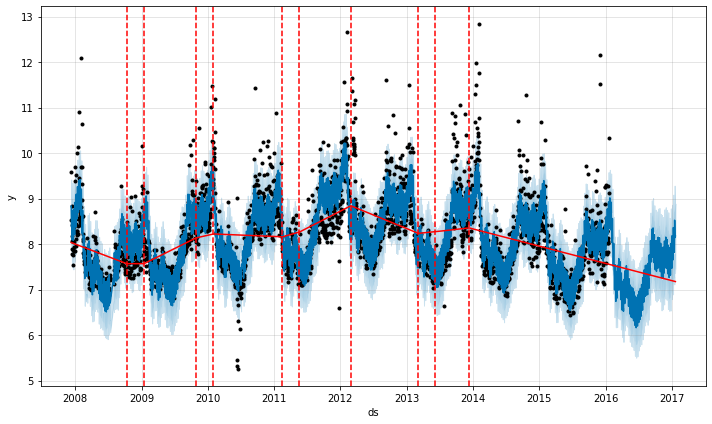

In [49]:
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
model = Prophet().fit(df)
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)
fig = model.plot(forecast)
a = fp.add_changepoints_to_plot(fig.gca(),model,forecast);

変化点の数を制御するためのパラメータは**`changepoint_prior_scale`**であり、既定値は0.05である。これを増やすと変化点が増え、予測の自由度が増すため予測幅が大きくなる。

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


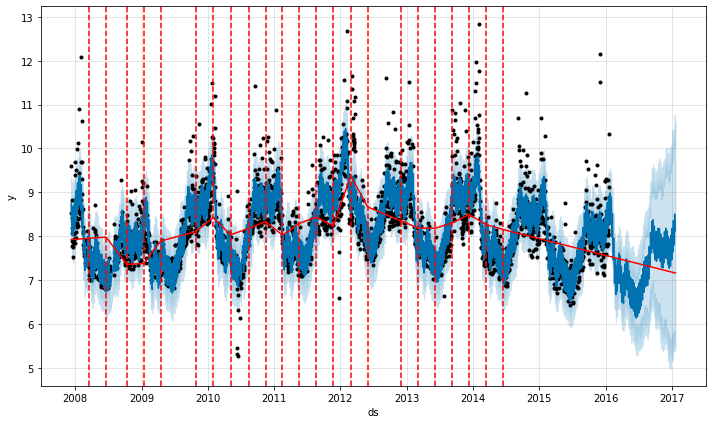

In [48]:
model = Prophet(changepoint_prior_scale=0.5).fit(df)
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)
fig = model.plot(forecast)
fp.add_changepoints_to_plot(fig.gca(), model, forecast);

傾向変化点のリストを`changepoints`引数で与えることもできる。以下の例では、1つの日だけで変化するように設定している。

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


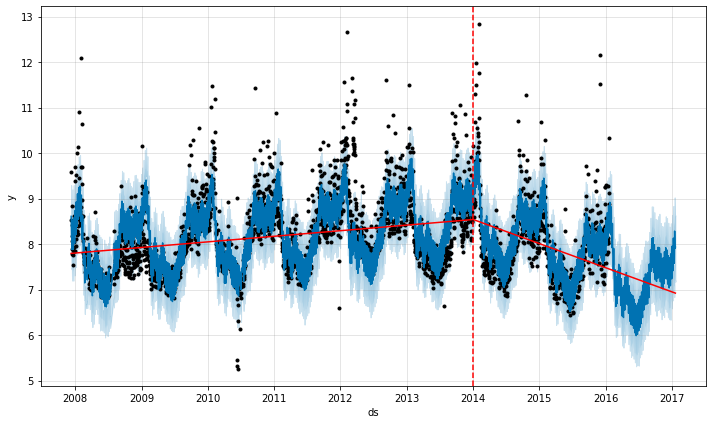

In [50]:
model = Prophet(changepoints=['2014-01-01']).fit(df)
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)
fig = model.plot(forecast)
fp.add_changepoints_to_plot(fig.gca(), model, forecast);



# SP500データ


株価の予測を行う．

傾向変化点の候補は自動的に設定される。既定値では時系列の最初の80%の部分に均等に設定される。これは、モデルの**changepoint_range**引数で設定する．
この例では，期間の終わりで変化点を設定したいので，0.95に変更する．

年次の季節変動の変化の度合いは、**yearly_seasonality**（既定値は10) で制御できる。この例では，このパラメータを5に変更することによって年間の季節変動を抑制して予測を行う．


In [52]:
sp500 = data.sp500()
sp500.tail()

,date,price
118,2009-11-01,1095.63
119,2009-12-01,1115.10
120,2010-01-01,1073.87
121,2010-02-01,1104.49
122,2010-03-01,1140.45


In [53]:
px.line(sp500,x="date",y="price") 

In [0]:
sp500.rename(inplace=True,columns={"date":"ds","price":"y"})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


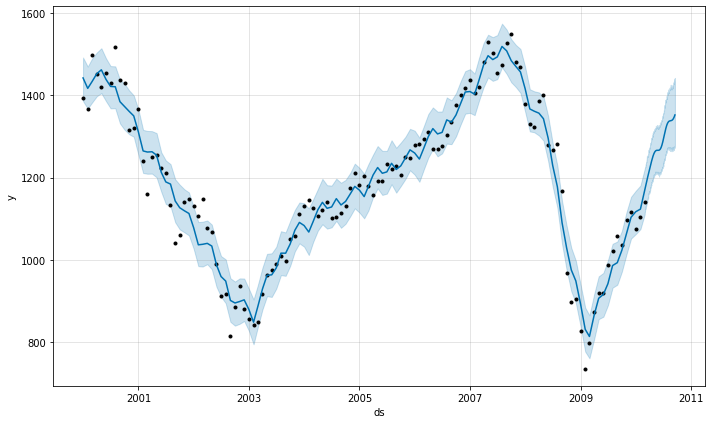

In [58]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.95,yearly_seasonality=5).fit(sp500)
future = model.make_future_dataframe(periods=200, freq='D')
forecast = model.predict(future)
model.plot(forecast);

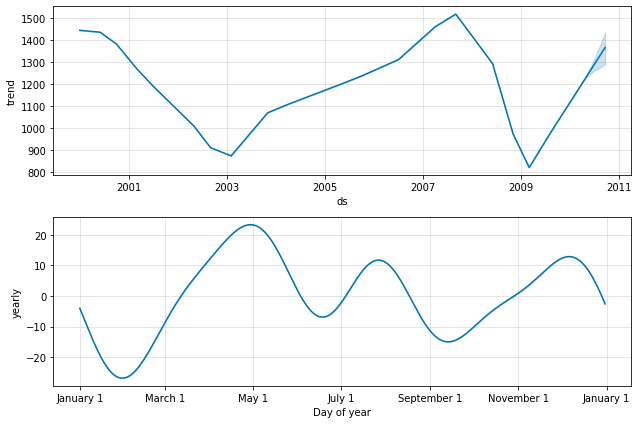

In [0]:
model.plot_components(forecast);

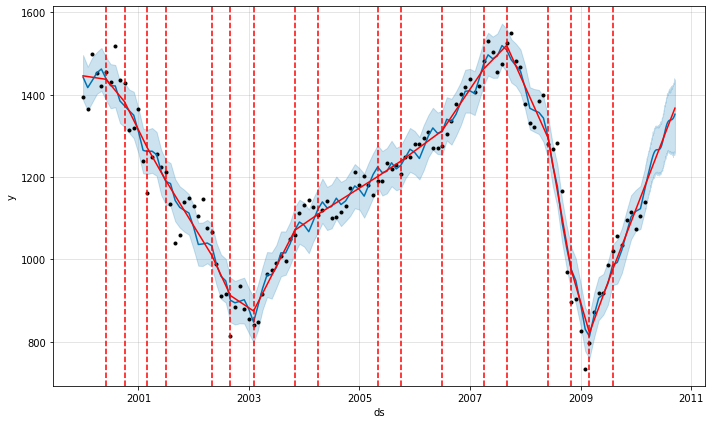

In [0]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

# 個別銘柄の株価の予測

stocksデータでは，symbol列に企業コードが入っている．

- AAPL アップル
- AMZN アマゾン
- IBM  IBM
- GOOG グーグル
- MSFT マイクロソフト

以下では，マイクロソフトの株価を予測してみる．

In [0]:
stocks = data.stocks()
stocks.tail()

,symbol,date,price
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62
559,AAPL,2010-03-01,223.02


In [0]:
px.line(stocks,x="date",y="price",color="symbol")

In [0]:
msft = stocks[ stocks.symbol == "MSFT"]
msft.head()

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45


In [0]:
msft = msft.rename(columns={"date":"ds","price":"y"})
msft.head()

,symbol,ds,y
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


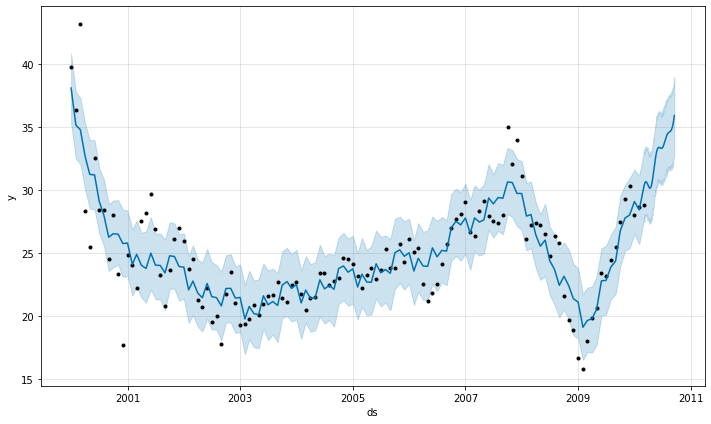

In [0]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.95,yearly_seasonality=5).fit(msft)
future = model.make_future_dataframe(periods=200, freq='D')
forecast = model.predict(future)
model.plot(forecast);

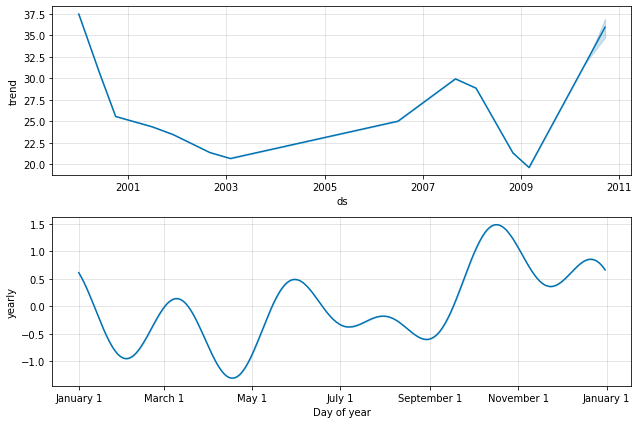

In [0]:
model.plot_components(forecast);

## 問題

上の株価データのマイクロソフト以外の銘柄を1つ選択し，予測を行え．

In [61]:
stocks = data.stocks()
stocks.head()

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45


# 発展編

以下では，Prophetの高度な使用法を解説する．

例としてPeyton Manningの例題のデータを用いる．

In [5]:
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


# 休日（特別なイベント）を考慮した予測

休日や特別なイベントをモデルに追加することを考える。そのためには、`holiday` と `ds`(datestamp)を列名としたデータフレームを準備する必要がある。`holiday`列にはイベント名を、`ds`にはそのイベントが発生する日時を入力する。また、イベントの影響が指定した日時の前後何日まで影響を与えるかを示す2つの列`lower_window`と `upper_window`を追加することができる。![代替テキスト](![代替テキスト](https://))

In [12]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays.head()

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1


引数holidaysで休日を表すデータフレームを与えることによって、特別なイベントを考慮した予測を行うことができる。

In [7]:
model= Prophet(holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


プレーオフやスーパーボールなどのイベント効果がある日だけ抜き出してデータフレームを表示する．

In [8]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.229999,1.176410
2191,2014-02-03,1.900543,1.486962
2532,2015-01-11,1.229999,0.000000
2533,2015-01-12,1.900543,0.000000
2901,2016-01-17,1.229999,0.000000
2902,2016-01-18,1.900543,0.000000
2908,2016-01-24,1.229999,0.000000
2909,2016-01-25,1.900543,0.000000
2922,2016-02-07,1.229999,1.176410
2923,2016-02-08,1.900543,1.486962


因子別に描画を行うと，イベントによって変化した量が描画される（上から2番目）．

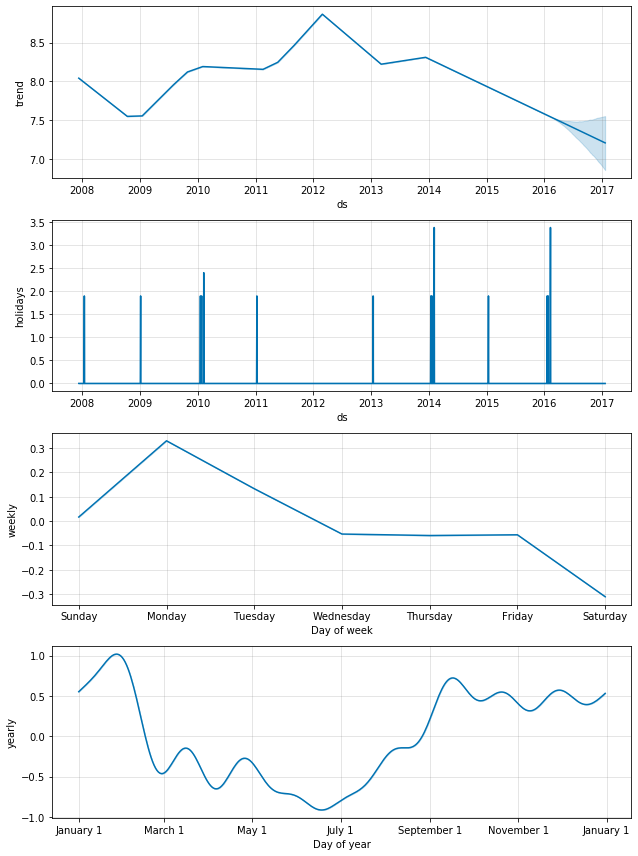

In [9]:
model.plot_components(forecast);


# 国（州）別の休日

`add_country_holidays`を用いて，各国（州）の休日データを追加することができる。日本のデータもあるが、天皇誕生日がずれていたりするので、注意を要する。

In [10]:
model = Prophet(holidays=holidays)
model.add_country_holidays(country_name='US')
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


追加された休日名を**train_holiday_names**属性で確認しておく．

In [14]:
model.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3     Martin Luther King, Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

米国の休日を考慮して予測を行い，因子別に描画してみる．上から2番目が，休日に対する影響を表している．

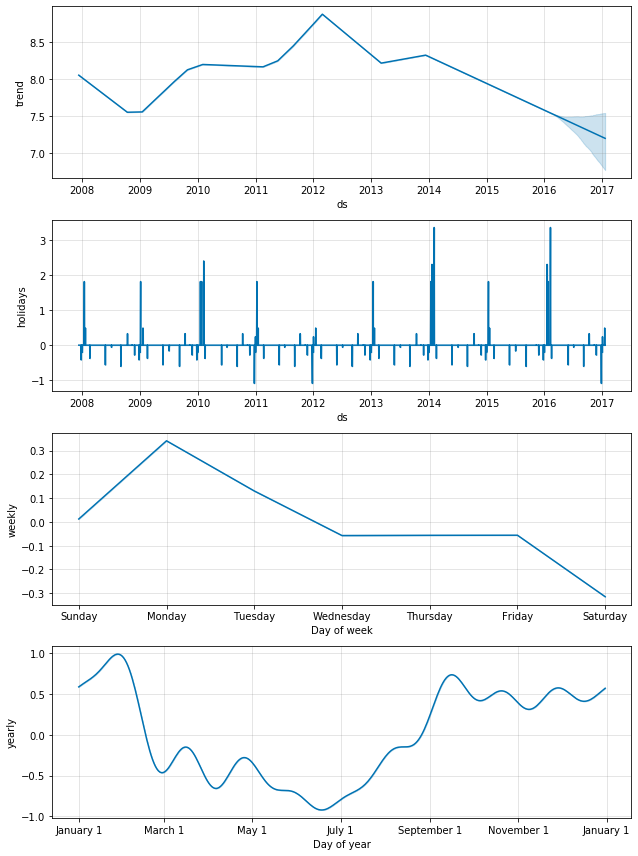

In [15]:
forecast = model.predict(future)
model.plot_components(forecast);


# ユーザーが設定した季節変動

Prophetでは規定値の年次や週次の季節変動だけでなく、ユーザー自身で季節変動を定義・追加できる。以下では、週次の季節変動を除き，かわりに周期が30.5日の月次変動をフーリエ次数（seasonalityの別名）5として追加している。

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


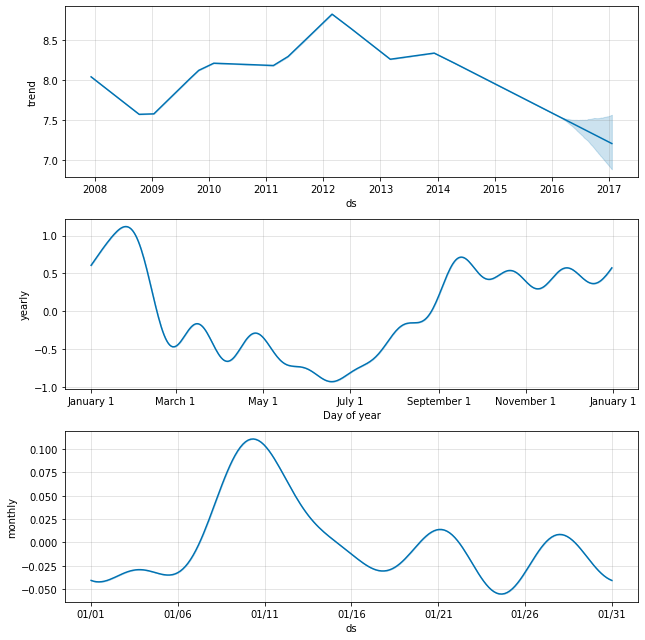

In [9]:
model = Prophet(weekly_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot_components(forecast);

# 他の要因に依存した季節変動

他の要因に依存した季節変動も定義・追加することができる。以下の例では、オンシーズンとオフシーズンごと週次変動を定義し、追加してみる。

In [0]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)
df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


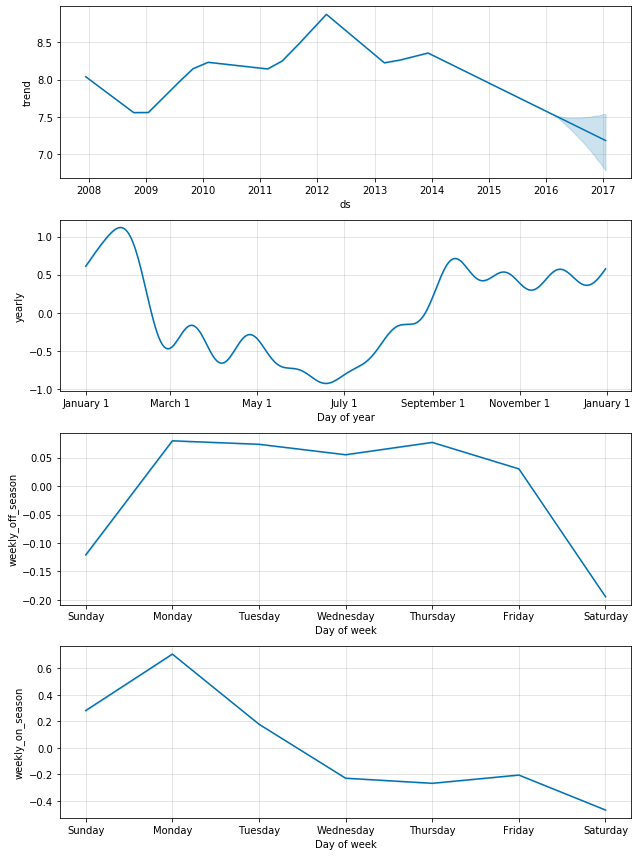

In [10]:
model = Prophet(weekly_seasonality=False)
model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
model.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
model.fit(df)
future = model.make_future_dataframe(periods=365)
future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast =model.predict(future)
model.plot_components(forecast);

# 休日と季節変動の効果の調整法

休日の影響を抑制するためには、`holidays_prior_scale`を小さくすれば良い。このパラメータの規定値は10であり、これはほとんど正則化を行わないことを意味する。一般に，prior_scaleを大きくするとそのパラメータの柔軟性が増し，小さくすると柔軟性が減る．以下では，`holidays_prior_scale`を0.05に設定して予測を行う．

In [14]:
model= Prophet(holidays=holidays, holidays_prior_scale=0.0,)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,playoff,superbowl
2190,2014-02-02,1.205344,0.963327
2191,2014-02-03,1.851992,0.991010
2532,2015-01-11,1.205344,0.000000
2533,2015-01-12,1.851992,0.000000
2901,2016-01-17,1.205344,0.000000
2902,2016-01-18,1.851992,0.000000
2908,2016-01-24,1.205344,0.000000
2909,2016-01-25,1.851992,0.000000
2922,2016-02-07,1.205344,0.963327
2923,2016-02-08,1.851992,0.991010


スーパーボール（superbowl）の効果が抑制されていることが見てとれる．
同様に，季節変動の影響は`seasonality_prior_scale`を小さくすることによって抑制できる。


# 不確実性の幅

Prophetは既定では傾向変動に対する不確実性の幅を予測する。このとき、引数`interval_width`で予測の幅を設定できる。既定値は0.8である。このパラメータを大きくすると幅が広がり、小さくすると幅が狭くなることが確認できる。

例としてCO2排出量のデータを用いる．

In [5]:
co2 = data.co2_concentration()
co2.rename(columns={"Date":"ds","CO2":"y"},inplace=True)
co2.head()

,ds,y
0,1958-03-01,315.70
1,1958-04-01,317.46
2,1958-05-01,317.51
3,1958-07-01,315.86
4,1958-08-01,314.93


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


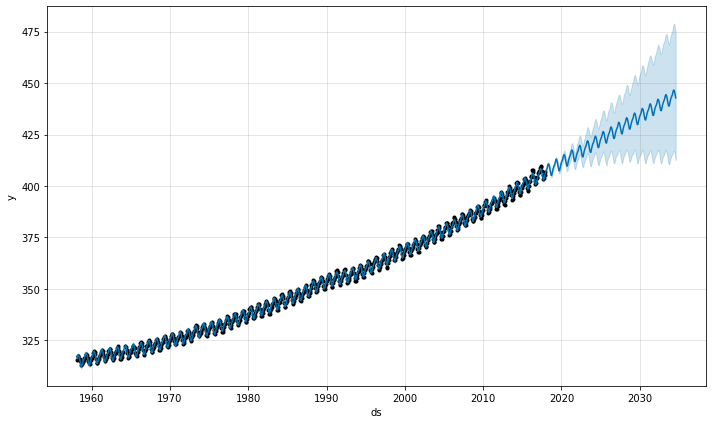

In [6]:
model = Prophet(interval_width=0.95)
model.fit(co2)
future = model.make_future_dataframe(periods=200, freq='M')
forecast = model.predict(future)
model.plot(forecast);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


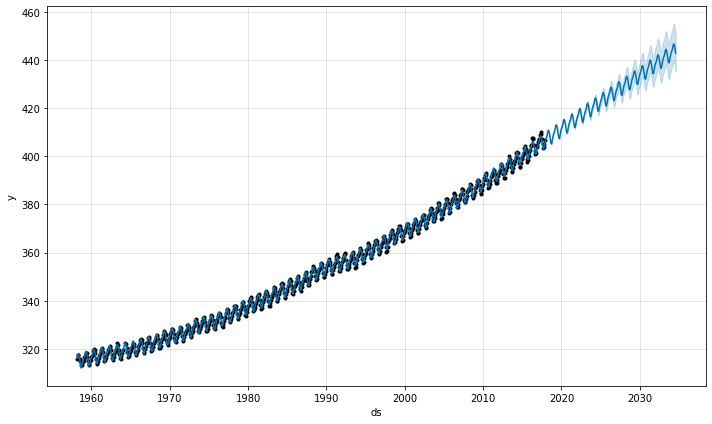

In [7]:
forecast = Prophet(interval_width=0.5).fit(co2).predict(future)
model.plot(forecast);

季節変動に対する不確実性を予測するためには、マルコフ連鎖モンテカルロ法を行う必要がある、そのためには、引数mcmc_samplesをシミュレーションの反復回数に設定する。このパラメータの規定値は0である。

これによって、規定値の最大事後確率（MAP）推定の代わりにマルコフ連鎖モンテカルロ法によるサンプリングが行われる。これは、非常に時間がかかることもある。 要因別に図を描画してみると、季節変動に対しても不確実性の幅が示されていることが確認できる。

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


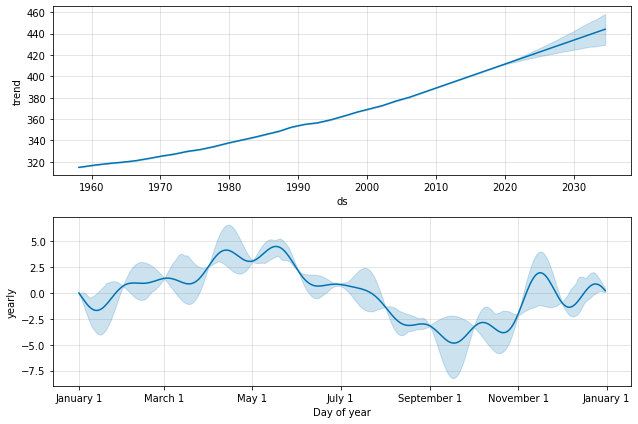

In [10]:
model = Prophet(mcmc_samples=100)
forecast = model.fit(co2).predict(future)
model.plot_components(forecast);

# 検証と誤差の評価

Prophetでは、予測の精度を検証するための仕組みが組み込まれている。例として、Peyton Manningのデータセットを用いる。
このデータセットは、全部で2905日分のデータで構成されている。

交差検証のためには、cross_validationを用いる。

引数は以下の通り．


- model: 予測を行うモデル；事前にfitメソッドで学習しておく必要がある．
- horizon : 計画期間（予測を行う期間）
- period : 予測の間隔；省略するとhorizonの半分が代入される．
- initial : 交差検証を開始する最初の期；省略するとhorizonの3倍が代入される．


以下の例では、initialが730日なので、729日までの情報を用いて、その後365(horizon)日の予測を行い、本当の値との誤差を評価し、次いで730+180(period)日までの情報を用いて、その後365日の予測を行い評価し、という手順を最後の日まで繰り返す。(2905-730-365)/180 = 10.05であるので、11回の予測を行い評価することになる。cross_validationは、交差検証用のデータフレームを返す。

最初の検証は730日後である2010-2-15(cutoff)までのデータを用いて，2010-2-16から365(horizon)日分の予測で行われ、次の検証はその180(period)日後である2010-08-14日から行われる。最後の検証は2015-01-20日までのデータを用いて2016-01-20日まで行われる。

In [33]:
df = pd.read_csv('http://logopt.com/data/peyton_manning.csv')
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.957184,8.487041,9.466852,8.242493,2010-02-15
1,2010-02-17,8.723619,8.161703,9.222267,8.008033,2010-02-15
2,2010-02-18,8.607378,8.106653,9.127685,8.045268,2010-02-15
3,2010-02-19,8.529250,8.048106,9.013602,7.928766,2010-02-15
4,2010-02-20,8.271228,7.793436,8.750862,7.745003,2010-02-15


In [36]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
3983,2016-01-16,8.592533,7.862822,9.311984,7.817223,2015-01-20
3984,2016-01-17,8.987133,8.224279,9.650186,9.273878,2015-01-20
3985,2016-01-18,9.293324,8.546972,10.034005,10.333775,2015-01-20
3986,2016-01-19,9.076513,8.330713,9.810008,9.125871,2015-01-20
3987,2016-01-20,8.912775,8.159286,9.629937,8.891374,2015-01-20


`performance_metrics` を用いてメトリクス（評価尺度）を計算する。評価尺度は、 平均平方誤差(mean squared error: MSE), 平均平方誤差の平方根 (root mean squared error: RMSE), 平均絶対誤差 (mean absolute error: MAE), 平均絶対パーセント誤差 (mean absolute percent error : MAPE),  `yhat_lower` と`yhat_upper` の間に入っている割合（被覆率: coverage) である。
 
 既定値では予測期間の最初の10%は除外して示される。これは、引数`rolling_window` によって変更できる。

In [37]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,0.494988,0.703554,0.506005,0.058644,0.671540
1,38 days,0.500795,0.707669,0.510999,0.059222,0.671540
2,39 days,0.523008,0.723193,0.517109,0.059824,0.670169
3,40 days,0.530268,0.728195,0.520003,0.060134,0.676336
4,41 days,0.537706,0.733284,0.521008,0.060214,0.683874


評価尺度は plot_cross_validation_metricで可視化できる。以下では平均絶対パーセント誤差(MAPE)を描画している．

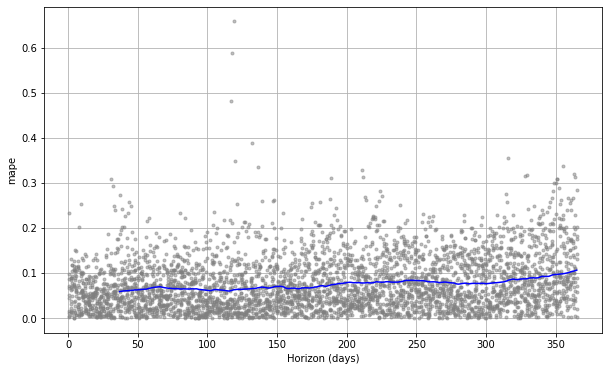

In [39]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mape');

Timedelta('0 days 00:10:00')


# まとめ

## 主なパラメータと規定値

- growth='linear' :傾向変動の関数．規定値は線形．ロジスティック曲線にするに'logistic'に設定する．
- changepoints=None :  傾向変更点のリスト
- n_changepoints=25 : 傾向変更点の数
- yearly_seasonality='auto' :  年次の季節変動を考慮するか否か
- weekly_seasonality='auto' : 週次の季節変動を考慮するか否か
- daily_seasonality='auto' : 日時の季節変動を考慮するか否か
- holidays=None : 休日のリスト
- seasonality_prior_scale=10.0 : 季節変動の事前分布のスケール値（パラメータの柔軟性をあら表す）
- holidays_prior_scale=10.0 : 休日のの事前分布のスケール値（パラメータの柔軟性をあら表す）
- changepoint_prior_scale=0.05 :  傾向変更点の事前分布のスケール値（パラメータの柔軟性をあら表す）
- mcmc_samples=0 : MCMC法のサンプル数
- interval_width=0.80 : 不確実性の幅 
- uncertainty_samples=1000 : 不確実性の幅を計算する際のサンプル数


In [0]:
model()